In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import sys

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.2.1 
xwmb version 0.2.1


### Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory ="/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch")
print(cluster.job_script())
cluster.scale(jobs=2)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.68:45828 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.68:45828,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [51]:
ds = xr.open_mfdataset(
        "../../data/model/budgets_sigma2/CM4Xp25_budgets_sigma2_2095-2099.zarr",
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds = ds.fillna(0.) #remove all NaNs
ds['mask'] = (
    (ds['geolat'] <= -40)
)

grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)


Text(0.5, 1.0, 'Southern Ocean mask')

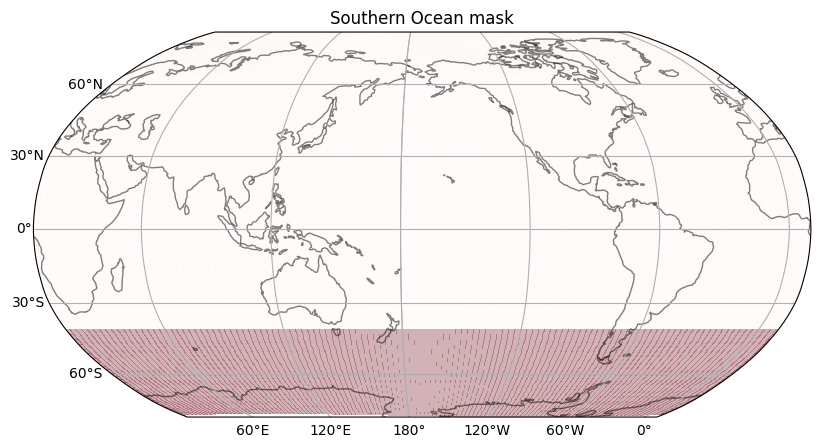

In [52]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
ax.pcolormesh(ds['geolon'], ds['geolat'] , ds['mask'], 
              transform = ccrs.PlateCarree(), cmap = "Reds", alpha = 0.3)
ax.coastlines(alpha = 0.5)
gl = ax.gridlines(draw_labels = True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Southern Ocean mask")

### Define region with ``regionate``

In [53]:
regions = MaskRegions(ds.mask, grid).region_dict
antarctic = regions[0] #there are more in this list if there are multiple contours 
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

In [54]:
def area_average(ds, varname, mask = None):
    if mask is None:
        mask = 1
        
    numerator = mask * ds[varname] * ds["areacello"] * ds["wet"]
    denominator = mask * ds["areacello"] * ds["wet"]
    numerator = numerator.where(denominator > 0)
    denominator = denominator.where(denominator > 0)
    return numerator.sum(["xh", "yh"]) / denominator.sum(["xh", "yh"])

In [65]:
averaged_siconc = area_average(ds, "siconc", mask = ds.mask).compute()
averaged_sfc_tmp = area_average(ds, "tos", mask = ds.mask).compute()

averaged_frsh_flx = area_average(ds, "LSNK", mask = ds.mask)
averaged_frsh_flx +=area_average(ds, "LSRC", mask = ds.mask)
averaged_frsh_flx = averaged_frsh_flx.compute()

In [83]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:                         (exp: 2, time: 60, yh: 90, xh: 120,
                                     sigma2_l: 74, time_bounds: 61, xq: 121,
                                     yq: 91, sigma2_i: 75)
Coordinates: (12/30)
    areacello                       (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho                          (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    dxCv                            (yq, xh) float64 87kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    dyCu                            (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * exp                             (exp) object 16B 'forced' 'control'
    geolat                          (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...                              ...
    wet_u                           (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    wet_v                           (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
  * xh                              (xh) int64 960B 0 1 2 3 ... 116 117 118 119
  * xq                              (xq) int64 968B 0 1 2 3 ... 117 118 119 120
  * yh                              (yh) int64 720B 0 1 2 3 4 ... 85 86 87 88 89
  * yq                              (yq) int64 728B 0 1 2 3 4 ... 86 87 88 89 90
Data variables: (12/39)
    EVAP                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    LSNK                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    LSRC                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    RAIN                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    SNOWFL                          (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    S_advection_xy                  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    ...                              ...
    tos                             (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    umo                             (exp, time, sigma2_l, yh, xq) float64 774MB dask.array<chunksize=(2, 60, 74, 90, 121), meta=np.ndarray>
    vert_remap_h_tendency           (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    vmo                             (exp, time, sigma2_l, yq, xh) float64 776MB dask.array<chunksize=(2, 60, 74, 91, 120), meta=np.ndarray>
    wfo                             (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    mask                            (yh, xh) bool 11kB dask.array<chunksize=(90, 120), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 20950101.ocean_static.nc
    description:         The CM4Xp25 experimental design following Griffies e...
    external_variables:  volcello areacello
    filename:            ocean_monthly_z.209501-209912.S_advection_xy.nc
    grid_tile:           N/A
    grid_type:           regular
    model:               CM4Xp25
    provenance:          Diagnostics have been conservatively remapped into m...
    title:               CM4_ssp585_c192_OM4p25
    version:             v0.1.0

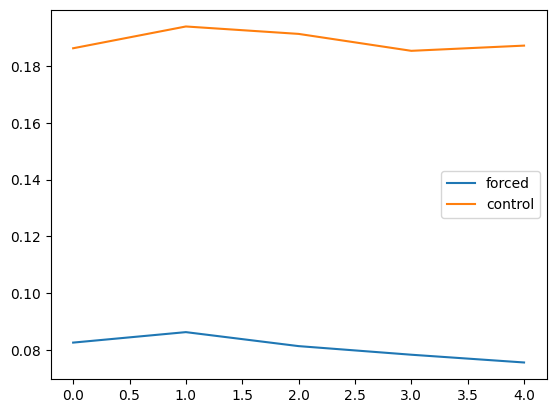

In [71]:
fig, ax = plt.subplots()
ax.plot(averaged_siconc.groupby("time.year").mean("time").sel(exp ='forced'), label = "forced")
ax.plot(averaged_siconc.groupby("time.year").mean("time").sel(exp ='control'), label = "control")
ax.legend()

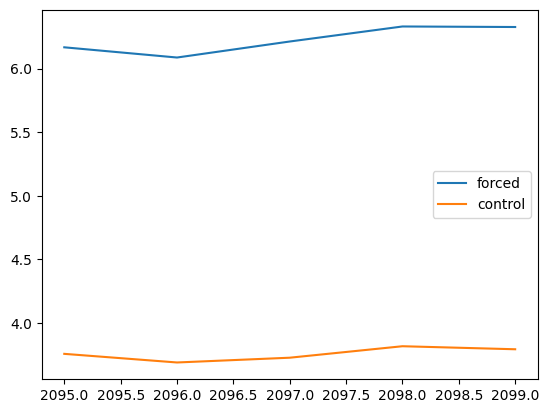

In [81]:
fig, ax = plt.subplots()
year_average = averaged_sfc_tmp.groupby("time.year").mean("time")
ax.plot(year_average.year, year_average.sel(exp ='forced'), label = "forced")
ax.plot(year_average.year, year_average.sel(exp ='control'), label = "control")
ax.legend()

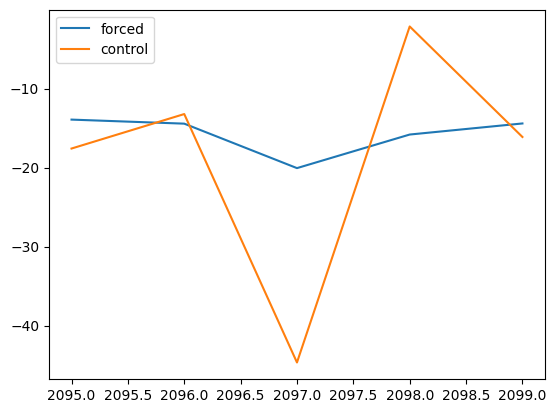

In [80]:
fig, ax = plt.subplots()
year_average = averaged_frsh_flx.groupby("time.year").mean("time")
ax.plot(year_average.year, year_average.sel(exp ='forced'), label = "forced")
ax.plot(year_average.year, year_average.sel(exp ='control'), label = "control")
ax.legend()

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        region
    ) #if region not passed, the whole globe is taken
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)

    wmb_3d = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        region
    ) #if region not passed, the whole globe is taken
    wmb_3d.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=False, along_section=False)
    #wmb.grid._ds["z"] this is where the z's are 

In [12]:
zonal_spurious_numerical_mixing = wmb_3d.wmt.spurious_numerical_mixing.sum([
                                    wmb_3d.grid.axes['X'].coords['center']]).mean("time")

zonal_spurious_numerical_mixing = zonal_spurious_numerical_mixing.compute()

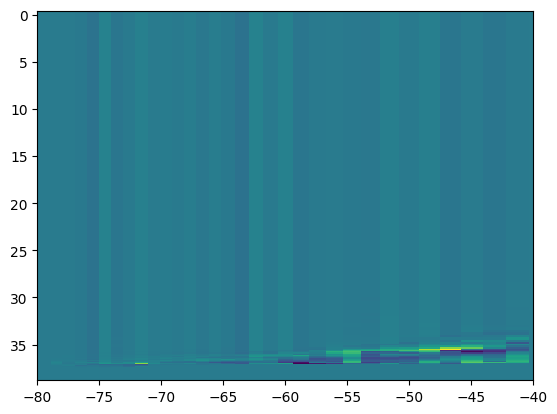

In [13]:
fig, ax = plt.subplots()

plt.pcolormesh(wmb_3d.wmt.geolat.mean("xh"), zonal_spurious_numerical_mixing.sigma2_l_target, 
             zonal_spurious_numerical_mixing.isel(exp = 0).T)
ax.set_xlim(-80, -40)
ax.invert_yaxis()

### Extract time-mean mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\leq + \mathcal{S}_\leq + \Psi_\leq + \mathcal{G}^{BF}_\leq + \mathcal{G}^{Mix}_\leq + \mathcal{G}^{Spurious}_\leq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\leq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\leq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\leq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\leq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\leq$.
- $\mathcal{G}^{BF}_\leq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\leq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\leq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [28]:
#advection budget 
wmt_bf = wmb.wmt.sel(sigma2_l_target = 37.00, method = "nearest").mean("time").compute()

In [63]:
wmt_bf

<xarray.Dataset> Size: 704kB
Dimensions:                                         (exp: 2,
                                                     sigma2_i_target: 75,
                                                     time_bounds: 61, yh: 112,
                                                     xh: 120)
Coordinates: (12/15)
  * exp                                             (exp) object 16B 'forced'...
    rho2_l                                          float64 8B 1.037e+03
    rho2_i                                          (sigma2_i_target) float64 600B ...
  * sigma2_i_target                                 (sigma2_i_target) float64 600B ...
  * time_bounds                                     (time_bounds) object 488B ...
    areacello                                       (yh, xh) float32 54kB 3.2...
    ...                                              ...
    lat                                             (yh, xh) float64 108kB -8...
    lon                                             (yh, xh) float64 108kB -2...
    wet                                             (yh, xh) float64 108kB 0....
  * xh                                              (xh) int64 960B 0 1 ... 119
  * yh                                              (yh) int64 896B 0 1 ... 111
    sigma2_l_target                                 float64 8B 37.0
Data variables: (12/39)
    frazil_ice_heat                                 (exp) float64 16B -2.081e...
    diffusion_heat                                  (exp) float64 16B -2.851e...
    diffusion_salt                                  (exp) float64 16B -1.279e...
    surface_ocean_flux_advective_negative_rhs_heat  (exp) float64 16B 2.307e+...
    surface_ocean_flux_advective_negative_rhs_salt  (exp) float64 16B 3.644e+...
    advection_heat                                  (exp) float64 16B 4.754e+...
    ...                                              ...
    mass_tendency                                   (exp) float64 16B -3.1e+0...
    dt                                              float64 8B 2.628e+06
    realized_transformation                         (exp) float64 16B -1.35e+...
    spurious_numerical_mixing                       (exp) float64 16B -2.028e...
    advection_plus_BC                               (exp) float64 16B 2.547e+...
    diabatic_advection                              (exp) float64 16B 2.545e+...

In [71]:
adv_tot = wmt_bf["surface_ocean_flux_advective_negative_rhs"]
adv_θ = wmt_bf["surface_ocean_flux_advective_negative_rhs_heat"]
adv_S = wmt_bf["surface_ocean_flux_advective_negative_rhs_salt"]

surfx_θ = wmt_bf["surface_exchange_flux_heat"]
surfx_S = wmt_bf["surface_exchange_flux_salt"]
surfx = wmt_bf["surface_exchange_flux"]

boundary_fluxes = wmt_bf["boundary_fluxes"]

frazil_θ = wmt_bf["frazil_ice_heat"] #this is the same as frazil ice
frazil = wmt_bf["frazil_ice"]

bottom_flux_θ = wmt_bf["bottom_flux_heat"]

boundary_fluxes_θ = surfx_θ + adv_θ + frazil_θ + bottom_flux_θ
boundary_fluxes_S = adv_S + surfx_S


In [73]:
print(f"BF = BFθ + BFS")
print(f"{boundary_fluxes} = {(boundary_fluxes_θ) + (boundary_fluxes_S)}")

BF = BFθ + BFS
<xarray.DataArray 'boundary_fluxes' (exp: 2)> Size: 16B
array([4.80799316e+09, 1.23170714e+10])
Coordinates:
  * exp              (exp) object 16B 'forced' 'control'
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0 = <xarray.DataArray (exp: 2)> Size: 16B
array([4.80799316e+09, 1.23170714e+10])
Coordinates:
  * exp              (exp) object 16B 'forced' 'control'
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0


<BarContainer object of 3 artists>

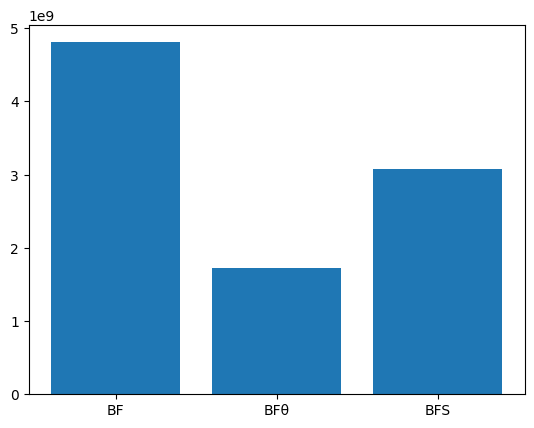

In [75]:
iexp = 0
plt.bar(["BF", "BFθ", "BFS"], 
        [boundary_fluxes.isel(exp = iexp), boundary_fluxes_θ.isel(exp = iexp), boundary_fluxes_S.isel(exp = iexp)])

In [68]:
print(f"BF = BFSF + BFAD + SFF + SFB")
print(f"{boundary_fluxes} = {surfx + adv_tot + frazil_θ + bottom_flux_θ}")

BF = BFSF + BFAD + SFF + SFB
<xarray.DataArray 'boundary_fluxes' (exp: 2)> Size: 16B
array([4.80799316e+09, 1.23170714e+10])
Coordinates:
  * exp              (exp) object 16B 'forced' 'control'
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0 = <xarray.DataArray (exp: 2)> Size: 16B
array([4.80799316e+09, 1.23170714e+10])
Coordinates:
  * exp              (exp) object 16B 'forced' 'control'
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 37.0


<BarContainer object of 7 artists>

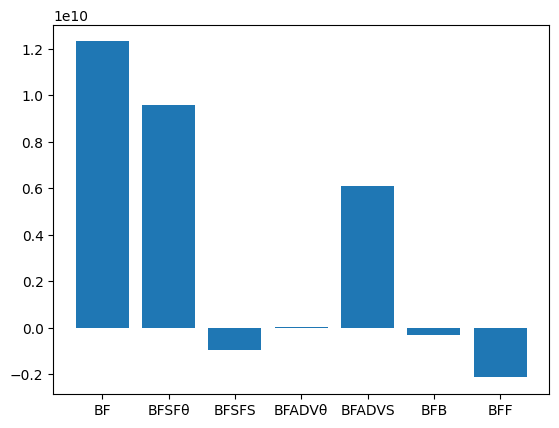

In [62]:
iexp = 1
plt.bar(["BF", "BFSFθ", "BFSFS", "BFADVθ", "BFADVS", "BFB", "BFF"], 
        [boundary_fluxes.isel(exp = iexp), surfx_θ.isel(exp = iexp), surfx_S.isel(exp = iexp), 
         adv_θ.isel(exp = iexp), adv_S.isel(exp = iexp), frazil_θ.isel(exp = iexp), bottom_flux_θ.isel(exp = iexp)])

<BarContainer object of 7 artists>

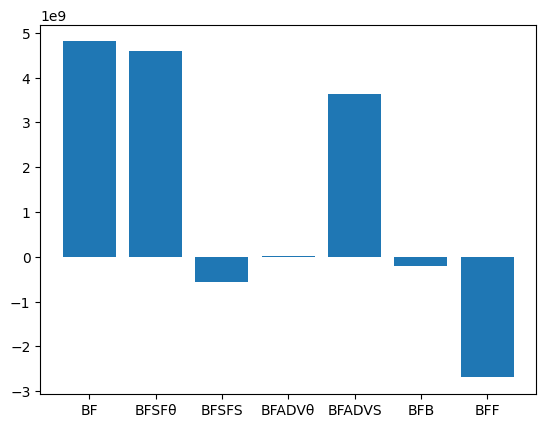

In [61]:
iexp = 0
plt.bar(["BF", "BFSFθ", "BFSFS", "BFADVθ", "BFADVS", "BFB", "BFF"], 
        [boundary_fluxes.isel(exp = iexp), surfx_θ.isel(exp = iexp), surfx_S.isel(exp = iexp), 
         adv_θ.isel(exp = iexp), adv_S.isel(exp = iexp), frazil_θ.isel(exp = iexp), bottom_flux_θ.isel(exp = iexp)])

In [64]:
diff_tot = wmt_bf["diffusion"]
diff_θ = wmt_bf["diffusion_heat"]
diff_S = wmt_bf["diffusion_salt"]

<BarContainer object of 3 artists>

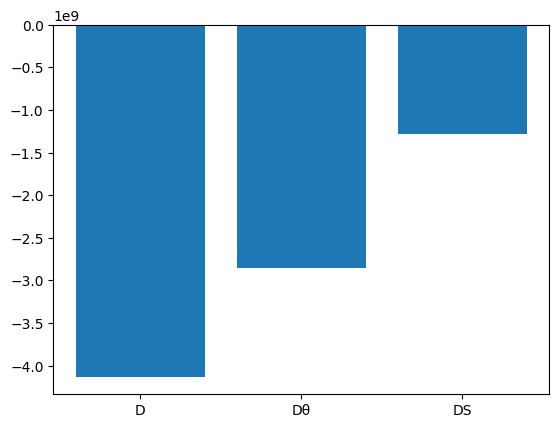

In [67]:
iexp = 0
plt.bar(["D", "Dθ", "DS"], 
        [diff_tot.isel(exp = iexp), diff_θ.isel(exp = iexp), diff_S.isel(exp = iexp)])

In [28]:
# Key water mass transformation budget terms
budget_terms = ['Eulerian_tendency', 'advection', 'diffusion', 
                'boundary_fluxes', 'convergent_mass_transport', 
               'mass_tendency', 'mass_source', 'spurious_numerical_mixing', 
               "surface_exchange_flux", "bottom_flux", "frazil_ice", 
                "surface_ocean_flux_advective_negative_rhs"]

wmt = wmb.wmt[budget_terms].mean("time").compute()

wmt = wmt.assign_coords({"sigma2_i_target": wmb.wmt["sigma2_i_target"].compute()})

### Checking the total budget

In [30]:
toSv = 1e-6/1035.

tend = toSv * wmt["mass_tendency"]

bterms = ['diffusion', 'boundary_fluxes', 'convergent_mass_transport', 
          'mass_source', 'spurious_numerical_mixing']
rem_budg = 0 * tend
for b in bterms:
    rem_budg += toSv * wmt[b]

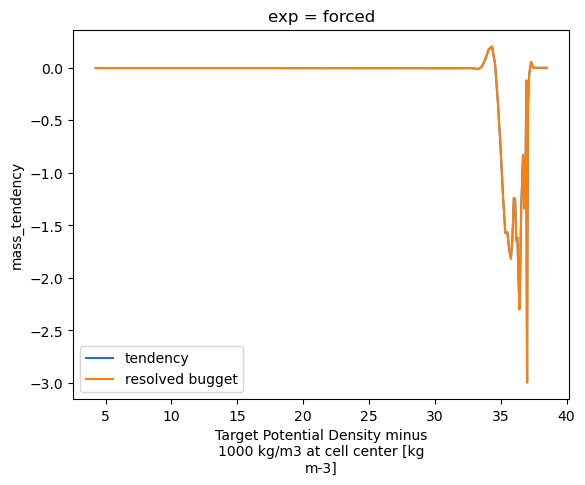

In [31]:
fig, ax = plt.subplots()
tend.isel(exp = 0).plot(ax = ax, label = "tendency")
rem_budg.isel(exp = 0).plot(ax = ax, label = "resolved bugget")
ax.legend()

### Checking the boundary flux budget

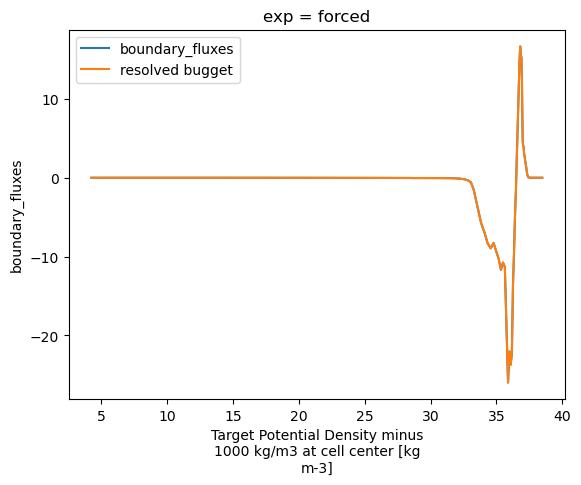

In [32]:
toSv = 1e-6/1035.

tend = toSv * wmt["boundary_fluxes"]

bterms = ["surface_exchange_flux", "bottom_flux", "frazil_ice", 
          "surface_ocean_flux_advective_negative_rhs"]
rem_budg = 0 * tend
for b in bterms:
    rem_budg += toSv * wmt[b]

fig, ax = plt.subplots()
tend.isel(exp = 0).plot(ax = ax, label = "boundary_fluxes")
rem_budg.isel(exp = 0).plot(ax = ax, label = "resolved bugget")
ax.legend()

### Checking the boundary flux tendency budget for $\sigma = 37.22$

5
5


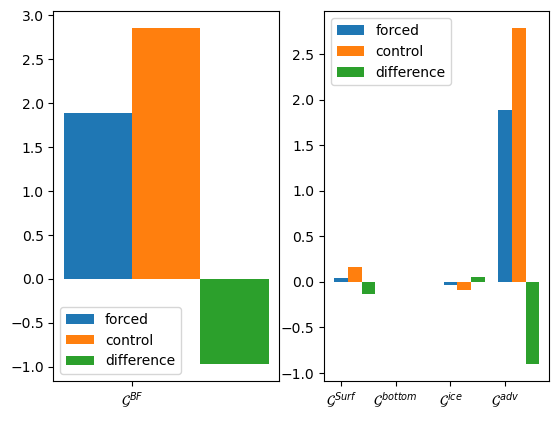

In [44]:
wmt_mean = toSv * wmt.sel(sigma2_l_target = 37.22, method = "nearest")

difference = -wmt_mean.diff(dim = "exp")
difference.coords['exp'] = ["difference"]
wmt_mean = xr.merge([wmt_mean, difference])
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

budgets = ['boundary_fluxes', 
           "surface_exchange_flux", #e.g., turbulent air-sea fluxes, radiative heating/cooling, sea ice brine rejection
           "bottom_flux", 
           "frazil_ice", 
          "surface_ocean_flux_advective_negative_rhs", #e.g., precipitation, evaporation, sea ice melt
          ]

budgets_labels = [r"$\mathcal{G}^{BF}$", 
                  r"$\mathcal{G}^{Surf}$",
                  r"$\mathcal{G}^{bottom}$",
                  r"$\mathcal{G}^{ice}$", 
                  r"$\mathcal{G}^{adv}$"]

print(len(budgets))
print(len(budgets_labels))

fig, ax = plt.subplots(1, 2, sharey = False)

width = 0.25
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)
    bvalues = [wmt_mean_budget[k].values for k in budgets]

    ax[0].bar(0 + curr_width, bvalues[0], label = exp, width = width)

    nterms = np.arange(len(budgets_labels[1:]))

    ax[1].bar(nterms + curr_width, bvalues[1:], label = exp, width = width)
    curr_width += width
    
[a.legend() for a in ax]

ax[0].set_xticks([width / 2], [budgets_labels[0]]);
ax[1].set_xticks(np.arange(len(budgets_labels[1:])), budgets_labels[1:]);

### Checking the mass budget for $\sigma = 37.22$

-0.015237457333265444
-0.01074295967881486
-0.004494497654450584


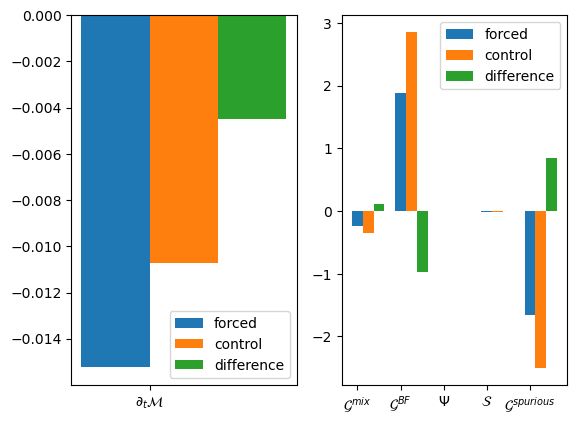

In [43]:
wmt_mean = toSv * wmt.sel(sigma2_l_target = 37.22, method = "nearest")

difference = -wmt_mean.diff(dim = "exp")
difference.coords['exp'] = ["difference"]
wmt_mean = xr.merge([wmt_mean, difference])
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

budgets = ['mass_tendency', 
           'diffusion', 
           'boundary_fluxes', 
           'convergent_mass_transport', 
           'mass_source', 
           'spurious_numerical_mixing']

budgets_labels = [r"$\partial_{t} \mathcal{M}$", 
                  r"$\mathcal{G}^{mix}$",
                  r"$\mathcal{G}^{BF}$", 
                  r"$\Psi$", 
                  r"$\mathcal{S}$", 
                  r"$\mathcal{G}^{spurious}$"]
fig, ax = plt.subplots(1, 2, sharey = False)

width = 0.25
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)
    print(wmt_mean_budget['mass_tendency'].values)
    bvalues = [wmt_mean_budget[k].values for k in budgets]

    ax[0].bar(0 + curr_width, bvalues[0], label = exp, width = width)

    nterms = np.arange(len(budgets_labels[1:]))

    ax[1].bar(nterms + curr_width, bvalues[1:], label = exp, width = width)
    curr_width += width
    
[a.legend() for a in ax]

ax[0].set_xticks([width / 2], [budgets_labels[0]]);
ax[1].set_xticks(np.arange(len(budgets_labels[1:])), budgets_labels[1:]);

In [58]:
integrate = lambda x: np.cumsum(np.concatenate([[0.], x.values]))
tendencies = toSv * wmb.wmt.sel(sigma2_l_target = 37.22, method = "nearest").compute()

Text(0.5, 0.98, 'Southern Ocean Mass Budget Terms')

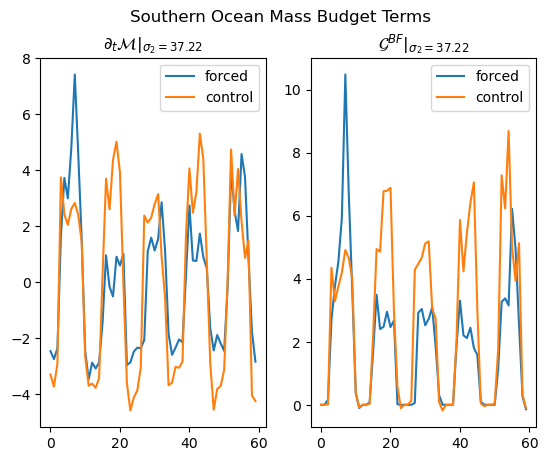

In [59]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(tendencies["mass_tendency"].isel(exp = 0), label = "forced")
ax[0].plot(tendencies["mass_tendency"].isel(exp = 1), label = "control")
ax[0].legend()

ax[1].plot(tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 0), label = "forced")
ax[1].plot(tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 1), label = "control")
ax[1].legend()

ax[0].set_title(r"$\partial_{t} \mathcal{M}|_{\sigma_2 = 37.22}$")
ax[1].set_title(r"$\mathcal{G}^{BF}|_{\sigma_2 = 37.22}$")

fig.suptitle("Southern Ocean Mass Budget Terms")